In [2]:
# -*- coding:utf-8 -*-

from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_1d, global_max_pool
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression
from tflearn.data_utils import to_categorical, pad_sequences
from sklearn.neural_network import MLPClassifier
from tflearn.layers.normalization import local_response_normalization
# from tensorflow.contrib import learn
import gensim
import re
from collections import namedtuple
from gensim.models import Doc2Vec
# from gensim.models.doc2vec import Doc2Vec,LabeledSentence
from random import shuffle
import multiprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn import preprocessing
from hmmlearn import hmm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from tflearn.layers.recurrent import bidirectional_rnn, BasicLSTMCell

cmdlines_file="../Data/MasqueradeDat/User7"
labels_file="../Data/MasqueradeDat/label.txt"
word2ver_bin="./Model/uba_word2vec.bin"
max_features=300
index = 80

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# 10.2　特征提取

## 10.2.1　词袋和TF-IDF模型

In [3]:
def get_cmdlines():
    x=np.loadtxt(cmdlines_file,dtype=str)
    x=x.reshape((150,100))
    y=np.loadtxt(labels_file, dtype=int,usecols=6)
    y=y.reshape((100, 1))
    y_train=np.zeros([50,1],int)
    y=np.concatenate([y_train,y])
    y=y.reshape((150, ))

    return x,y
x,y = get_cmdlines()

In [6]:
import pandas as pd
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,cpp,sh,xrdb,cpp,sh,xrdb,mkpts,test,stty,hostname,...,MediaMai,sendmail,sh,rm,MediaMai,sh,rm,MediaMai,launchef,launchef
1,sh,sh,more,sh,sh,rm,MediaMai,netstat,netscape,netscape,...,netscape,netscape,ls,mc,lc,pwd,tput,date,ls,mc
2,lc,netstat,netscape,netscape,netscape,netscape,netscape,netscape,netscape,netscape,...,sh,reaper,[,cat,stty,hostname,date,echo,[,find
3,chmod,tty,echo,sh,more,sh,rm,sh,MediaMai,ex,...,sh,more,sh,more,sh,more,sh,more,sh,more
4,sh,more,sh,sh,rm,MediaMai,xrn,sh,sh,more,...,MediaMai,sh,sh,rm,MediaMai,sh,sh,rm,MediaMai,sh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,FIFO,cat,date,generic,generic,date,generic,gethost,download,tcpostio,...,rm,UNLOCK,rmdir,generic,tcppost,sh,LOCK,hostname,id,nawk
146,getopt,true,true,grep,date,lp,find,tail,ls,sed,...,echo,env,echo,sh,userenv,wait4wm,xhost,xsetroot,xmodmap,sh
147,reaper,[,cat,stty,hostname,date,echo,[,find,chmod,...,sh,more,sh,more,sh,more,sh,more,sh,more
148,sh,more,sh,more,sh,more,sh,more,sh,more,...,LOCK,generic,tcppost,sh,gs,ghostvie,rm,gzip,sh,sh


In [7]:
pd.DataFrame(y)

,0
0,0
1,0
2,0
3,0
4,0
...,...
145,0
146,0
147,0
148,0


In [8]:
def get_features_by_wordbag():
    global max_features
    global  index
    x_arr,y=get_cmdlines()
    x=[]

    for i,v in enumerate(x_arr):
        v=" ".join(v)
        x.append(v)

    vectorizer = CountVectorizer(
                                 decode_error='ignore',
                                 strip_accents='ascii',
                                 max_features=max_features,
                                 stop_words='english',
                                 max_df=1.0,
                                 min_df=1 )
    x=vectorizer.fit_transform(x)

    x_train=x[0:index,]
    x_test=x[index:,]
    y_train=y[0:index,]
    y_test=y[index:,]

    transformer = TfidfTransformer(smooth_idf=False)
    transformer.fit(x)
    x_test = transformer.transform(x_test)
    x_train = transformer.transform(x_train)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_features_by_wordbag()

In [18]:
pd.DataFrame(x_train.data)

,0
0,0.075901
1,0.151803
2,0.080384
3,0.075901
4,0.080384
...,...
2089,0.072496
2090,0.042182
2091,0.085324
2092,0.039055


## 10.2.2　词袋和N-Gram模型

In [20]:
def get_features_by_ngram():
    global max_features
    global  index
    x_arr,y=get_cmdlines()
    x=[]

    for i,v in enumerate(x_arr):
        v=" ".join(v)
        x.append(v)

    vectorizer = CountVectorizer(
                                 ngram_range=(2, 4),
                                 token_pattern=r'\b\w+\b',
                                 decode_error='ignore',
                                 strip_accents='ascii',
                                 max_features=max_features,
                                 stop_words='english',
                                 max_df=1.0,
                                 min_df=1 )
    x=vectorizer.fit_transform(x)

    x_train=x[0:index,]
    x_test=x[index:,]
    y_train=y[0:index,]
    y_test=y[index:,]

    transformer = TfidfTransformer(smooth_idf=False)
    transformer.fit(x)
    x_test = transformer.transform(x_test)
    x_train = transformer.transform(x_train)

    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = get_features_by_ngram()

In [24]:
pd.DataFrame(x_train.toarray())

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.063822,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.024978,0.036366,0.036820,0.000000,0.00000
2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.070881,0.066825,0.042436,0.000000,0.000000,0.000000,0.07444
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.204303,0.049575,0.050194,0.000000,0.00000
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.013179,0.000000,0.000000,0.021049,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.172804,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
76,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.037733,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
77,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
78,0.063653,0.0,0.0,0.0,0.061807,0.061807,0.061807,0.054357,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


## 10.2.3　词汇表模型

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_features_by_wordseq():
    global max_features
    global index
    x_arr, y = get_cmdlines()
    x = [" ".join(v) for v in x_arr]

    tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    x = pad_sequences(sequences, maxlen=max_features)

    x_train = x[:index]
    x_test = x[index:]
    y_train = y[:index]
    y_test = y[index:]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_features_by_wordseq()

In [27]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0,0,0,0,0,0,0,0,0,0,...,12,13,2,9,12,2,9,12,15,15
1,0,0,0,0,0,0,0,0,0,0,...,3,3,6,18,19,38,43,8,6,18
2,0,0,0,0,0,0,0,0,0,0,...,74,83,2,82,7,36,11,8,16,14
3,0,0,0,0,0,0,0,0,0,0,...,2,5,2,5,2,5,2,5,2,5
4,0,0,0,0,0,0,0,0,0,0,...,12,2,2,9,12,2,2,9,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0,0,0,0,0,0,0,0,0,...,21,21,11,25,26,27,10,10,17,8
76,0,0,0,0,0,0,0,0,0,0,...,24,47,32,47,32,24,47,32,24,100
77,0,0,0,0,0,0,0,0,0,0,...,47,32,47,32,2,123,2,13,13,2
78,0,0,0,0,0,0,0,0,0,0,...,8,4,4,8,4,64,67,24,24,24


# 10.3　模型训练与验证
## 10.3.1　朴素贝叶斯算法

In [33]:
def do_nb(x_train, x_test, y_train, y_test):
    gnb = GaussianNB()
    gnb.fit(x_train,y_train)
    y_pred=gnb.predict(x_test)
    print(classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))

x_train, x_test, y_train, y_test = get_features_by_wordbag()
do_nb(x_train.toarray(), x_test.toarray(), y_train, y_test)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        64
           1       0.71      0.83      0.77         6

    accuracy                           0.96        70
   macro avg       0.85      0.90      0.87        70
weighted avg       0.96      0.96      0.96        70

[[62  2]
 [ 1  5]]


In [35]:
x_train, x_test, y_train, y_test = get_features_by_wordseq()
do_nb(x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84        64
           1       0.25      1.00      0.40         6

    accuracy                           0.74        70
   macro avg       0.62      0.86      0.62        70
weighted avg       0.94      0.74      0.80        70

[[46 18]
 [ 0  6]]


In [36]:
x_train, x_test, y_train, y_test = get_features_by_ngram()
do_nb(x_train.toarray(), x_test.toarray(), y_train, y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.67      0.80         6

    accuracy                           0.97        70
   macro avg       0.98      0.83      0.89        70
weighted avg       0.97      0.97      0.97        70

[[64  0]
 [ 2  4]]


## 10.3.2　XGBoost算法

In [37]:
def do_xgboost(x_train, x_test, y_train, y_test):
    xgb_model = xgb.XGBClassifier().fit(x_train, y_train)
    y_pred = xgb_model.predict(x_test)
    print(classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))

x_train, x_test, y_train, y_test = get_features_by_wordbag()
do_xgboost(x_train.toarray(), x_test.toarray(), y_train, y_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.50      0.67         6

    accuracy                           0.96        70
   macro avg       0.98      0.75      0.82        70
weighted avg       0.96      0.96      0.95        70

[[64  0]
 [ 3  3]]


In [38]:
x_train, x_test, y_train, y_test = get_features_by_wordseq()
do_xgboost(x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.91      0.98      0.95        64
           1       0.00      0.00      0.00         6

    accuracy                           0.90        70
   macro avg       0.46      0.49      0.47        70
weighted avg       0.83      0.90      0.87        70

[[63  1]
 [ 6  0]]


In [39]:
x_train, x_test, y_train, y_test = get_features_by_ngram()
do_xgboost(x_train.toarray(), x_test.toarray(), y_train, y_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       1.00      0.83      0.91         6

    accuracy                           0.99        70
   macro avg       0.99      0.92      0.95        70
weighted avg       0.99      0.99      0.99        70

[[64  0]
 [ 1  5]]


## 10.3.3　隐式马尔可夫算法

In [43]:
def  get_features_by_wordseq_hmm():
    global max_features
    global index
    x_arr, y = get_cmdlines()
    x = [" ".join(v) for v in x_arr]

    tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    x = pad_sequences(sequences, maxlen=max_features)

    x_train = x[0:50, ]
    x_test = x[50:, ]
    y_train = y[0:50, ]
    y_test = y[50:, ]

    return x_train, x_test, y_train, y_test

### 找最佳阈值

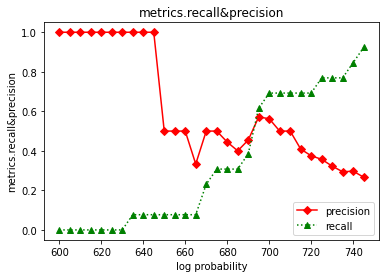

In [115]:
def show_hmm(trainX, testX, trainY, y_test):
    a=[]
    b=[]
    c=[]

    N=2
    lengths=[1]
    X=[[0]]
    for i in trainX:
        z=[]
        for j in i:
            z.append([j])
        X=np.concatenate([X,np.array(z)])
        lengths.append(len(i))

    remodel = hmm.GaussianHMM(n_components=N, covariance_type="full", n_iter=100)
    remodel.fit(X, lengths)

    for T in range(600,750,5):
        y_predict = []
        for i in testX:
            z = []
            for j in i:
                z.append([j])
            y_pred = remodel.score(z)
            # print(y_pred)
            if y_pred < T:
                y_predict.append(1)
            else:
                y_predict.append(0)
        y_predict = np.array(y_predict)
        precision=precision_score(y_test,y_predict, zero_division=1)
        recall=recall_score(y_test,y_predict)
        a.append(T)
        b.append(precision)
        c.append(recall)

    plt.plot(a, b,'-rD',a,c, ':g^')
    plt.legend(['precision', 'recall'])
    plt.xlabel("log probability")
    plt.ylabel("metrics.recall&precision")
    plt.title("metrics.recall&precision")
    plt.show()
    return y_test,y_predict
x_train, x_test, y_train, y_test = get_features_by_wordseq_hmm()
y_test,y_pr = show_hmm(x_train, x_test, y_train, y_test)

In [120]:
def do_hmm(trainX, testX, trainY, testY):
    T=710
    N=2
    lengths=[1]
    X=[[0]]
    print(len(trainX))
    for i in trainX:
        z=[]
        for j in i:
            z.append([j])
        #print z
        #X.append(z)
        X=np.concatenate([X,np.array(z)])
        lengths.append(len(i))

    remodel = hmm.GaussianHMM(n_components=N, covariance_type="full", n_iter=100) # 使用隐式马尔可夫算法，特征提取词汇
    remodel.fit(X, lengths)

    y_predict=[]
    for i in testX:
        z=[]
        for j in i:
            z.append([j])
        y_pred=remodel.score(z)
        # print(y_pred)
        # 其中设置阈值T，当测试样本与正常行为基线的相似度小于T时，认为是疑似异常操作
        if y_pred < T:
            y_predict.append(1)
        else:
            y_predict.append(0)
    y_predict=np.array(y_predict)

    print(classification_report(testY, y_predict))
    print(metrics.confusion_matrix(testY, y_predict))

    # print(testY)
    # print(y_predict)

x_train, x_test, y_train, y_test = get_features_by_wordseq_hmm()
do_hmm(x_train, x_test, y_train, y_test)

50
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        87
           1       0.50      0.69      0.58        13

    accuracy                           0.87       100
   macro avg       0.73      0.79      0.75       100
weighted avg       0.89      0.87      0.88       100

[[78  9]
 [ 4  9]]


## 10.3.4　深度学习算法之MLP

In [121]:
def do_mlp(x_train, x_test, y_train, y_test):
    global max_features
    # Building deep neural network
    clf = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        hidden_layer_sizes = (5, 2),
                        random_state = 1)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))

x_train, x_test, y_train, y_test = get_features_by_wordseq()
do_mlp(x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        64
           1       0.00      0.00      0.00         6

    accuracy                           0.91        70
   macro avg       0.46      0.50      0.48        70
weighted avg       0.84      0.91      0.87        70

[[64  0]
 [ 6  0]]


d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
x_train, x_test, y_train, y_test = get_features_by_ngram()
do_mlp(x_train, x_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        64
           1       0.00      0.00      0.00         6

    accuracy                           0.91        70
   macro avg       0.46      0.50      0.48        70
weighted avg       0.84      0.91      0.87        70

[[64  0]
 [ 6  0]]


d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def buildWordVector(imdb_w2v,text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += imdb_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec


def  get_features_by_word2vec():
    global word2ver_bin
    global index
    global max_features

    x_all=[]

    x_arr,y=get_cmdlines()

    x=[]

    for i,v in enumerate(x_arr):
        v=" ".join(v)
        x.append(v)

    for i in range(1,30):
        filename="../Data/MasqueradeDat/User%d" % i
        with open(filename) as f:
            x_all.append([w.strip('\n') for w in f.readlines()])


    cores=multiprocessing.cpu_count()

    if os.path.exists(word2ver_bin):
        print("Find cache file %s" % word2ver_bin)
        model=gensim.models.Word2Vec.load(word2ver_bin)
    else:
        model=gensim.models.Word2Vec(size=max_features, window=5, min_count=1, iter=60, workers=cores)
        model.build_vocab(x_all)
        model.train(x_all, total_examples=model.corpus_count, epochs=model.iter)
        #model.save(word2ver_bin)

    x = np.concatenate([buildWordVector(model, z, max_features) for z in x])
    x = scale(x)


    x_train = x[0:index,]
    x_test = x[index:,]

    y_train = y[0:index,]
    y_test = y[index:,]

    return x_train, x_test, y_train, y_test



def do_cnn(trainX, testX, trainY, testY):
    global max_features
    y_test = testY
    #trainX = pad_sequences(trainX, maxlen=max_features, value=0.)
    #testX = pad_sequences(testX, maxlen=max_features, value=0.)
    # Converting labels to binary vectors
    trainY = to_categorical(trainY, nb_classes=2)
    testY = to_categorical(testY, nb_classes=2)

    # Building convolutional network
    network = input_data(shape=[None,max_features], name='input')
    network = tflearn.embedding(network, input_dim=1000, output_dim=128,validate_indices=False)
    branch1 = conv_1d(network, 128, 2, padding='valid', activation='relu', regularizer="L2")
    branch2 = conv_1d(network, 128, 3, padding='valid', activation='relu', regularizer="L2")
    branch3 = conv_1d(network, 128, 4, padding='valid', activation='relu', regularizer="L2")
    network = merge([branch1, branch2, branch3], mode='concat', axis=1)
    network = tf.expand_dims(network, 2)
    network = global_max_pool(network)
    network = dropout(network, 1)
    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target')
    # Training
    model = tflearn.DNN(network, tensorboard_verbose=0)
    model.fit(trainX, trainY,
              n_epoch=10, shuffle=True, validation_set=0,
              show_metric=True, batch_size=10,run_id="uba")

    y_predict_list = model.predict(testX)

    y_predict = []
    for i in y_predict_list:
        if i[0] > 0.5:
            y_predict.append(0)
        else:
            y_predict.append(1)

    print(classification_report(y_test, y_predict))
    print(metrics.confusion_matrix(y_test, y_predict))

def do_rnn_wordbag(trainX, testX, trainY, testY):
    y_test=testY
    #trainX = pad_sequences(trainX, maxlen=100, value=0.)
    #testX = pad_sequences(testX, maxlen=100, value=0.)
    # Converting labels to binary vectors
    trainY = to_categorical(trainY, nb_classes=2)
    testY = to_categorical(testY, nb_classes=2)

    # Network building
    net = tflearn.input_data([None, 100])
    net = tflearn.embedding(net, input_dim=1000, output_dim=128)
    net = tflearn.lstm(net, 128, dropout=0.1)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', learning_rate=0.005,
                             loss='categorical_crossentropy')

    # Training
    model = tflearn.DNN(net, tensorboard_verbose=0)
    model.fit(trainX, trainY, validation_set=0.1, show_metric=True,
              batch_size=1,run_id="uba",n_epoch=10)

    y_predict_list = model.predict(testX)
    #print(y_predict)_list

    y_predict = []
    for i in y_predict_list:
        #print  i[0]
        if i[0] >= 0.5:
            y_predict.append(0)
        else:
            y_predict.append(1)

    print(classification_report(y_test, y_predict))
    print(metrics.confusion_matrix(y_test, y_predict))

    print(y_train)

    print("ture")
    print(y_test)
    print("pre")
    print(y_predict)

def do_birnn_wordbag(trainX, testX, trainY, testY):
    y_test=testY
    #trainX = pad_sequences(trainX, maxlen=100, value=0.)
    #testX = pad_sequences(testX, maxlen=100, value=0.)
    # Converting labels to binary vectors
    trainY = to_categorical(trainY, nb_classes=2)
    testY = to_categorical(testY, nb_classes=2)

    # Network building
    # Network building
    net = input_data(shape=[None, 100])
    net = tflearn.embedding(net, input_dim=10000, output_dim=128)
    net = tflearn.bidirectional_rnn(net, BasicLSTMCell(128), BasicLSTMCell(128))
    net = dropout(net, 0.5)
    net = fully_connected(net, 2, activation='softmax')
    net = regression(net, optimizer='adam', loss='categorical_crossentropy')

    # Training
    model = tflearn.DNN(net, tensorboard_verbose=0)
    model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True,
              batch_size=1,run_id="uba",n_epoch=10)

    y_predict_list = model.predict(testX)
    #print(y_predict)_list

    y_predict = []
    for i in y_predict_list:
        #print  i[0]
        if i[0] >= 0.5:
            y_predict.append(0)
        else:
            y_predict.append(1)

    print(classification_report(y_test, y_predict))
    print(metrics.confusion_matrix(y_test, y_predict))